In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2021-11-01 02:16:04.094642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-01 02:16:04.094668: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
transition_window =3

warmup_start = '20210428'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210601'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

log_dir = './logs/new_warmup'


# Learning rate
learning_rate = 1e-4

In [3]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)

In [4]:
class Comp(Enum):
    A = 0
    M = 1
    #X = 2
    #G = 3
    
class Vax(Enum):
    total = -1
    no = 0
    yes = 1

In [68]:
# get warmup arrays, splitting on vaccination status
warmup_asymp, warmup_mild, warmup_extreme = create_warmup(df, 
                                                          warmup_start, 
                                                          warmup_end,
                                                          0,0,0)

# re-combine
warmup_asymp = warmup_asymp[Vax.no.value] + warmup_asymp[Vax.yes.value]

In [6]:
x_train = tf.cast(df.loc[train_start:train_end,'Rt'].values, dtype=tf.float32)
y_test = tf.cast(df.loc[train_start:train_end,'mild'], dtype=tf.float32)

2021-11-01 02:16:06.466642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-01 02:16:06.466832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-01 02:16:06.466866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-01 02:16:06.466893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-01 02:16:06.466919: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [90]:
synth_delta = 0.99
synth_T_serial = 5.8
synth_rho_M = 0.76
synth_lambda_M = 4.7
synth_nu_M = 3.1

In [8]:

model_delta = 0.995
model_T_serial = 5.3
model_rho_M = 0.8
model_lambda_M = 5.0
model_nu_M = 2.6
model_asymp = warmup_asymp+50

In [91]:
A_vals = []
M_vals =[]
for day in range(transition_window):
    A_vals.append(warmup_asymp[day])

for day in range(len(x_train)):
    yesterday_asymp = A_vals[-1]
    
    today_asymp = yesterday_asymp*synth_delta*x_train[day]**(1/synth_T_serial)
    A_vals.append(today_asymp)
    
    today_M = 0
    pi_M=[]
    for j in range(transition_window):
        
        
        lambda_M_fix = synth_lambda_M
        nu_M_fix = synth_nu_M
        poisson_dist = scipy.stats.poisson(lambda_M_fix)
        pi_M_j_ago = poisson_dist.logpmf(j+1)/nu_M_fix
        
        pi_M.append(pi_M_j_ago)
    
    pi_M = scipy.special.softmax(pi_M)
        
    for j in range(transition_window):
        j_ago_asymp = A_vals[day-j-1]
        today_M += j_ago_asymp*synth_rho_M*pi_M[j]
        
    M_vals.append(today_M)

In [107]:
param_scale_pcts = np.logspace(-2, -1, 20, dtype=np.float32)
trials = 10

losses = {}
for param_scale_pct in param_scale_pcts:
    print(f'New pct!: {param_scale_pct}')
    losses[param_scale_pct] = []
    for trial in range(trials):
        delta = {}
        delta[Vax.total.value] = {}
        delta[Vax.total.value]['prior'] = {'a': 18, 'b': 2}
        # delta is 0-1, so we will sigmoid the output of the variational posterior
        # Here we use a reverse sigmoid to convert from a mean of 0.1
        # scales are positive, so we invert sofplus


        delta[Vax.total.value]['posterior_init'] = {'loc': np.log(model_delta/(1-synth_delta)),
                                                    'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*synth_delta),dtype=tf.float32)}

        T_serial = {}
        T_serial[Vax.total.value] = {}
        T_serial[Vax.total.value]['prior'] ={'loc':5.8, 'scale':1}
        # T_serial is positive, so we will softplus the output of the variational posterior
        # Here we use a reverse softplus to convert from a mean of 5.8
        # I cant figure out the math to do for the scale parameter
        T_serial[Vax.total.value]['posterior_init'] = {'loc': tfp.math.softplus_inverse(synth_T_serial),
                                                 'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*synth_T_serial),dtype=tf.float32)}


        rho_M = {}
        rho_M[Vax.total.value] = {}
        rho_M[Vax.total.value]['prior'] = {'a': 31.8, 'b': 10.3}
        # rho is 0-1, so we will sigmoid the output of the variational posterior
        # Here we use a reverse sigmoid to convert from a mean of 0.76
        # I cant figure out the math to do for the scale parameter
        rho_M[Vax.total.value]['posterior_init'] = {'loc': np.log(synth_rho_M/(1-synth_rho_M)),
                                              'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*synth_rho_M),dtype=tf.float32)}

        lambda_M = {}
        lambda_M[Vax.total.value] = {}
        lambda_M[Vax.total.value]['prior'] = {'loc': 4.7, 'scale': 1}
        # lambda is positive, so we will softplus the output of the variational posterior
        # Here we use a reverse softplus to convert from a mean of 4.7
        # I cant figure out the math to do for the scale parameter
        lambda_M[Vax.total.value]['posterior_init'] = {'loc': tfp.math.softplus_inverse(synth_lambda_M),
                                                 'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*synth_lambda_M),dtype=tf.float32)}

        nu_M = {}
        nu_M[Vax.total.value] = {}
        nu_M[Vax.total.value]['prior'] = {'loc': 3.1, 'scale': 1.2}
        # nu is positive, so we will softplus the output of the variational posterior
        # Here we use a reverse softplus to convert from a mean of 3.1
        # I cant figure out the math to do for the scale parameter
        nu_M[Vax.total.value]['posterior_init'] = {'loc': tfp.math.softplus_inverse(synth_nu_M),
                                             'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*synth_nu_M),dtype=tf.float32)}

        warmup_A_params = {}
        warmup_A_params[Vax.total.value] = {}
        warmup_A_params[Vax.total.value]['prior'] = []
        warmup_A_params[Vax.total.value]['posterior_init'] = []

        for day in range(transition_window):
            warmup_A_params[Vax.total.value]['prior'].append({'loc': warmup_asymp[day],
                                                        'scale': warmup_asymp[day]/10})
            # must be positive so reverse softplus the mean
            warmup_A_params[Vax.total.value]['posterior_init'].append({'loc': tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]),dtype=tf.float32),
                                                                 'scale': tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]*param_scale_pct),dtype=tf.float32)})#tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]/10),dtype=tf.float32)})
            
        model = CovidModel([Vax.total], [Comp.A, Comp.M],
                         transition_window,
                         delta, T_serial, rho_M, lambda_M, nu_M,
                         warmup_A_params, posterior_samples=1000)
        loss = LogPoissonProb() 
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=learning_rate, #momentum=0.98, nesterov=False, name='SGD'
        )
        
       

        with tf.GradientTape() as tape:
            result = model.call(x_train)
            loss_val = loss(tf.cast(np.array(M_vals),dtype=tf.float32), result)
            loss_val += sum(model.losses)
            
        losses[param_scale_pct].append(loss_val)
        

New pct!: 0.01
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.009900001809000969
Pre-softmax pi_M [[-0.98727    -1.0434653  -1.0092863  ... -1.0245634  -1.0072522
  -0.9908757 ]
 [-0.7197532  -0.7606874  -0.7357363  ... -0.7468984  -0.73425496
  -0.722401  ]
 [-0.5822978  -0.6103823  -0.5919709  ... -0.59959775 -0.59169763
  -0.58482945]]
Delta 0.9896908402442932
T serial 5.583213806152344
rho_M 0.7549268007278442
lambda M 4.553400039672852
pi_M [0.25643972 0.34242585 0.3930231 ]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.009900001809000969
Pre-softmax pi_M [[-1.0210187  -1.0109588  -1.0117483  ... -1.0197875  -1.0359892
  -1.0505841 ]
 [-0.7443947  -0.7369914  -0.73752993 ... -0.7434235  -0.75522333
  -0.7659487 ]
 [-0.59592855 -0.5954581  -0.5937653  ... -0.59660715 -0.6064255
  -0.61320066]]
Delta 0.9896638989448547
T serial 5.60441780090332
rho_M 0.7548852562904358
lambda M 4.575

In [ ]:
losses

In [ ]:
plt.plot(param_scale_pcts[:10],
         [losses[param_scale_pct] for param_scale_pct in param_scale_pcts[:10]], 'k.')
plt.xscale('log')
plt.xlabel('Std. Dev. as a percentage of of mean')
plt.ylabel('Negative ELBO')
plt.title("Performance vs Parameter Std. Deviation")

In [96]:
import copy;
possibilities = {
    'delta': [0.98, 0.985, 0.99, 0.995, 0.998],
    'T_serial': [3.0, 4.5, 5.8, 7.0, 9.0],
    'rho_M': [0.5, 0.65, 0.76, 0.8, 0.9],
    'lambda_M': [2.0, 3.0, 4.7, 6.0, 9.0],
    'nu_M': [1.5, 2.5, 3.1, 4.0, 5.0],
    'warmup_asymp_-3': copy.copy([warmup_asymp[0]-400, warmup_asymp[0]-200, warmup_asymp[0], warmup_asymp[0]+200, warmup_asymp[0]+400]),
    'warmup_asymp_-2': copy.copy([warmup_asymp[1]-400, warmup_asymp[1]-200, warmup_asymp[1], warmup_asymp[1]+200, warmup_asymp[1]+400]),
    'warmup_asymp_-1': copy.copy([warmup_asymp[2]-400, warmup_asymp[2]-200, warmup_asymp[2], warmup_asymp[2]+200, warmup_asymp[2]+400]),
}

diff_pcts = np.linspace(0, 0.20, 20)
param_scale_pct = 0.1
losses = {}
grad_mag = {}
for key in [ 'warmup_asymp_-2', 'warmup_asymp_-1']:#possibilities.keys():
    print(f'New key!: {key}')
    model_delta = synth_delta
    model_T_serial = synth_T_serial
    model_rho_M = synth_rho_M
    model_lambda_M = synth_lambda_M
    model_nu_M = synth_nu_M
    model_asymp = copy.copy(warmup_asymp)
    
    losses[key] = []
    grad_mag[key] = []
    
    for diff_idx in range(5):
        model_asymp =  copy.copy(warmup_asymp)

        if key =='delta':
            model_delta = possibilities[key][diff_idx]
        if key =='T_serial':
            model_T_serial = possibilities[key][diff_idx]
        if key =='rho_M':
            model_rho_M = possibilities[key][diff_idx]
        if key =='lambda_M':
            model_lambda_M = possibilities[key][diff_idx]
        if key =='nu_M':
            model_nu_M = possibilities[key][diff_idx]
        if key =='warmup_asymp_-3':
            model_asymp[0] = possibilities[key][diff_idx]
        if key =='warmup_asymp_-2':
            model_asymp[1] = possibilities[key][diff_idx]
        if key =='warmup_asymp_-1':
            model_asymp[2] = possibilities[key][diff_idx]

            

        
        for trial in range(trials):



            delta = {}
            delta[Vax.total.value] = {}
            delta[Vax.total.value]['prior'] = {'a': 18, 'b': 2}
            # delta is 0-1, so we will sigmoid the output of the variational posterior
            # Here we use a reverse sigmoid to convert from a mean of 0.1
            # scales are positive, so we invert sofplus


            delta[Vax.total.value]['posterior_init'] = {'loc': tf.cast(np.log(model_delta/(1-model_delta)),dtype=tf.float32),
                                                        'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*model_delta),dtype=tf.float32)}

            T_serial = {}
            T_serial[Vax.total.value] = {}
            T_serial[Vax.total.value]['prior'] ={'loc':5.8, 'scale':1}
            # T_serial is positive, so we will softplus the output of the variational posterior
            # Here we use a reverse softplus to convert from a mean of 5.8
            # I cant figure out the math to do for the scale parameter
            T_serial[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(model_T_serial),dtype=tf.float32),
                                                     'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*model_T_serial),dtype=tf.float32)}


            rho_M = {}
            rho_M[Vax.total.value] = {}
            rho_M[Vax.total.value]['prior'] = {'a': 31.8, 'b': 10.3}
            # rho is 0-1, so we will sigmoid the output of the variational posterior
            # Here we use a reverse sigmoid to convert from a mean of 0.76
            # I cant figure out the math to do for the scale parameter
            rho_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(np.log(model_rho_M/(1-model_rho_M)),dtype=tf.float32),
                                                  'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*model_rho_M),dtype=tf.float32)}

            lambda_M = {}
            lambda_M[Vax.total.value] = {}
            lambda_M[Vax.total.value]['prior'] = {'loc': 4.7, 'scale': 1}
            # lambda is positive, so we will softplus the output of the variational posterior
            # Here we use a reverse softplus to convert from a mean of 4.7
            # I cant figure out the math to do for the scale parameter
            lambda_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(model_lambda_M),dtype=tf.float32),
                                                     'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*model_lambda_M),dtype=tf.float32)}

            nu_M = {}
            nu_M[Vax.total.value] = {}
            nu_M[Vax.total.value]['prior'] = {'loc': 3.1, 'scale': 1.2}
            # nu is positive, so we will softplus the output of the variational posterior
            # Here we use a reverse softplus to convert from a mean of 3.1
            # I cant figure out the math to do for the scale parameter
            nu_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(model_nu_M),dtype=tf.float32),
                                                 'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*model_nu_M),dtype=tf.float32)}

            warmup_A_params = {}
            warmup_A_params[Vax.total.value] = {}
            warmup_A_params[Vax.total.value]['prior'] = []
            warmup_A_params[Vax.total.value]['posterior_init'] = []

            for day in range(transition_window):
                warmup_A_params[Vax.total.value]['prior'].append({'loc': warmup_asymp[day],
                                                            'scale': warmup_asymp[day]/10})
                # must be positive so reverse softplus the mean
                warmup_A_params[Vax.total.value]['posterior_init'].append({'loc': tf.cast(tfp.math.softplus_inverse(model_asymp[day]),dtype=tf.float32),
                                                                     'scale': tf.cast(tfp.math.softplus_inverse(model_asymp[day]*param_scale_pct),dtype=tf.float32)})#tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]/10),dtype=tf.float32)})

            model = CovidModel([Vax.total], [Comp.A, Comp.M],
                             transition_window,
                             delta, T_serial, rho_M, lambda_M, nu_M,
                             warmup_A_params, posterior_samples=1000)
            loss = LogPoissonProb() 
            optimizer = tf.keras.optimizers.SGD(
                learning_rate=learning_rate, #momentum=0.98, nesterov=False, name='SGD'
            )



            with tf.GradientTape() as tape:
                result = model.call(x_train)
                loss_val = loss(tf.cast(np.array(M_vals),dtype=tf.float32), result)
                loss_val += sum(model.losses)

            grads = tape.gradient(loss_val, model.trainable_weights)

            losses[key].append(loss_val)
            grad_mag[key].append(np.mean(grads))



New key!: warmup_asymp_-2
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0990000069141388
Pre-softmax pi_M [[-1.0498071  -1.0715034  -1.3128908  ... -0.8222712  -0.8158065
  -1.1554111 ]
 [-0.7664601  -0.7810898  -0.96268183 ... -0.5994767  -0.59530246
  -0.84544057]
 [-0.606721   -0.6286255  -0.75338423 ... -0.48526284 -0.48754528
  -0.66434926]]
Delta 0.9864687919616699
T serial 3.445570468902588
rho_M 0.7115075588226318
lambda M 3.0570383071899414
pi_M [0.2273481  0.33840168 0.34907126]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0990000069141388
Pre-softmax pi_M [[-1.1880924  -1.0331577  -0.9600423  ... -1.135649   -1.0216109
  -0.9354157 ]
 [-0.87152636 -0.75323766 -0.7002554  ... -0.8294541  -0.74584925
  -0.6843278 ]
 [-0.6816199  -0.6031183  -0.5575713  ... -0.65548694 -0.6133604
  -0.57015264]]
Delta 0.985745906829834
T serial 4.084417343139648
rho_M 0.7163248062133789
lambda

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0990000069141388
Pre-softmax pi_M [[-1.3953496  -1.0621392  -1.1080256  ... -1.2208745  -1.0284084
  -1.2040465 ]
 [-1.017178   -0.7758555  -0.8095286  ... -0.8900322  -0.7501529
  -0.87775964]
 [-0.8173571  -0.61284614 -0.6389892  ... -0.71383905 -0.5970942
  -0.70938236]]
Delta 0.9863137006759644
T serial 3.90055513381958
rho_M 0.7106943130493164
lambda M 3.1500775814056396
pi_M [0.21699406 0.3356622  0.35061833]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0990000069141388
Pre-softmax pi_M [[-0.68240595 -1.1456343  -1.3312546  ... -1.0330281  -1.2398633
  -0.86533684]
 [-0.50136673 -0.8356517  -0.97530997 ... -0.7531653  -0.90612274
  -0.6329176 ]
 [-0.426036   -0.68169236 -0.76440084 ... -0.6103238  -0.71449226
  -0.52666694]]
Delta 0.9866706728935242
T serial 3.83451771736145
rho_M 0.7127385139465332
lambda M 3.322922706604004
pi_M [0

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0990000069141388
Pre-softmax pi_M [[-1.1029887  -0.84135777 -0.97334105 ... -1.0313684  -1.0171717
  -0.810002  ]
 [-0.8041913  -0.613609   -0.7095622  ... -0.7519335  -0.7414892
  -0.6009415 ]
 [-0.6519759  -0.49962205 -0.5731194  ... -0.6089472  -0.5961614
  -0.5281196 ]]
Delta 0.9861640930175781
T serial 4.074869155883789
rho_M 0.7117995619773865
lambda M 3.457104444503784
pi_M [0.223393   0.33679655 0.35823044]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0990000069141388
Pre-softmax pi_M [[-0.98511827 -1.2688053  -1.03242    ... -0.90549934 -1.001633
  -1.1764902 ]
 [-0.7189582  -0.9292392  -0.75276244 ... -0.6609278  -0.7303109
  -0.8596133 ]
 [-0.5702253  -0.728776   -0.6106295  ... -0.5425329  -0.592358
  -0.6783422 ]]
Delta 0.9865267276763916
T serial 3.7030117511749268
rho_M 0.7140406966209412
lambda M 3.3887221813201904
pi_M [0.

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0990000069141388
Pre-softmax pi_M [[-1.2145417  -0.9203377  -1.3641505  ... -1.284524   -0.85496134
  -1.1804321 ]
 [-0.88663626 -0.6711146  -1.0028865  ... -0.9416295  -0.6255486
  -0.8639445 ]
 [-0.702215   -0.5453816  -0.782194   ... -0.7372326  -0.5215379
  -0.6785287 ]]
Delta 0.9863411784172058
T serial 3.6335830688476562
rho_M 0.7156869769096375
lambda M 3.221979856491089
pi_M [0.21861994 0.33546796 0.35190955]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0990000069141388
Pre-softmax pi_M [[-0.9162461  -0.9199432  -1.349621   ... -1.1468185  -0.96836865
  -0.8763308 ]
 [-0.67273974 -0.6708798  -0.99016565 ... -0.8370749  -0.7059227
  -0.63964   ]
 [-0.5701563  -0.5351417  -0.7742353  ... -0.66345507 -0.5670679
  -0.5250759 ]]
Delta 0.9858638048171997
T serial 4.067169189453125
rho_M 0.7072832584381104
lambda M 3.213880777359009
pi_M 

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0990000069141388
Pre-softmax pi_M [[-1.1940603  -1.0435616  -0.86429596 ... -0.9426099  -0.99026316
  -0.84454787]
 [-0.87173015 -0.76155233 -0.6317677  ... -0.69636214 -0.7228259
  -0.6157843 ]
 [-0.69023454 -0.6042764  -0.5238361  ... -0.60376817 -0.593536
  -0.49957278]]
Delta 0.9861313700675964
T serial 4.081526756286621
rho_M 0.7113605737686157
lambda M 3.334252119064331
pi_M [0.22683695 0.33813748 0.35786834]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0990000069141388
Pre-softmax pi_M [[-1.008862   -0.9367187  -1.1310259  ... -0.8469896  -1.0248436
  -1.0464203 ]
 [-0.73579437 -0.6833771  -0.8247235  ... -0.6202708  -0.74707645
  -0.76366234]
 [-0.5993462  -0.55845475 -0.6587001  ... -0.51952684 -0.601217
  -0.60584116]]
Delta 0.9855276942253113
T serial 4.008083820343018
rho_M 0.7155170440673828
lambda M 2.7975668907165527
pi_M [0

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0990000069141388
Pre-softmax pi_M [[-0.88344467 -0.8657451  -0.9185889  ... -1.14021    -0.95278084
  -1.2228651 ]
 [-0.6440021  -0.6341138  -0.67022634 ... -0.8314971  -0.6947597
  -0.891431  ]
 [-0.51814103 -0.5315659  -0.53243166 ... -0.6633903  -0.5644422
  -0.7184504 ]]
Delta 0.9864722490310669
T serial 4.017651081085205
rho_M 0.6992400884628296
lambda M 3.038891077041626
pi_M [0.22736207 0.33798057 0.3497488 ]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0990000069141388
Pre-softmax pi_M [[-1.3030136  -0.815738   -1.0135084  ... -1.0497464  -0.9960796
  -1.2638261 ]
 [-0.9525255  -0.6077411  -0.73980284 ... -0.7657041  -0.72981924
  -0.9233885 ]
 [-0.7504542  -0.5406765  -0.60753876 ... -0.62458795 -0.6127726
  -0.728774  ]]
Delta 0.985942542552948
T serial 3.9006497859954834
rho_M 0.7101902961730957
lambda M 3.1557352542877197
pi_M 

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0990000069141388
Pre-softmax pi_M [[-1.1805891  -1.0893794  -0.9849302  ... -1.2974687  -1.1254767
  -1.2070985 ]
 [-0.86194354 -0.7945713  -0.7186372  ... -0.947512   -0.8204341
  -0.8841467 ]
 [-0.6823047  -0.6328252  -0.5708557  ... -0.749213   -0.6605862
  -0.69325656]]
Delta 0.9849300384521484
T serial 3.7599689960479736
rho_M 0.7107299566268921
lambda M 3.300849437713623
pi_M [0.22535275 0.33807427 0.35986498]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0990000069141388
Pre-softmax pi_M [[-0.94879925 -0.91028374 -1.0046202  ... -1.1105167  -0.7991692
  -0.895469  ]
 [-0.69164425 -0.666793   -0.7323889  ... -0.81003094 -0.58276814
  -0.6530094 ]
 [-0.5563677  -0.55919236 -0.59221965 ... -0.64484817 -0.47370917
  -0.52108055]]
Delta 0.9862192869186401
T serial 4.090526103973389
rho_M 0.7085083723068237
lambda M 3.2796459197998047
pi_M

In [82]:
plt.plot(diff_pcts,
         [losses[diff_pct] for diff_pct in diff_pcts], 'k.')
plt.xscale('log')
plt.xlabel('Std. Dev. as a percentage of of mean')
plt.ylabel('Negative ELBO')
plt.title("Performance vs % Deviation from Truth")

KeyError: 0.0

In [22]:
plt.plot(diff_pcts,
         [grad_mag[diff_pct] for diff_pct in diff_pcts], 'k.')
plt.xscale('log')
plt.xlabel('Abs % difference from True Parameters')
plt.ylabel('Average Gradient')
plt.title("Gradient Magnitude vs % Deviation from Truth")

KeyError: 0.0

In [ ]:
grad_mag

In [ ]:
result

Text(0.5, 1.0, 'Loss vs. Mean Delta value')

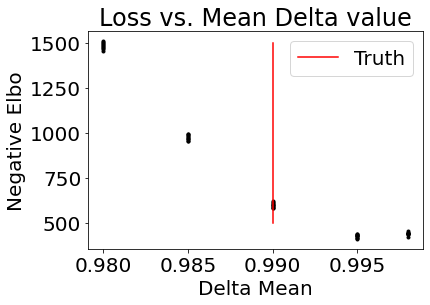

In [85]:
plt.plot(np.repeat(possibilities['delta'],10),
         losses['delta'], 'k.')
plt.plot([synth_delta, synth_delta], [500, 1500], 'r-', label='Truth')
plt.xlabel('Delta Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean Delta value")

Text(0.5, 1.0, 'Loss vs. Mean T_serial value')

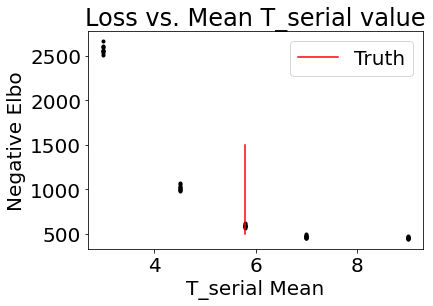

In [29]:
plt.plot(np.repeat(possibilities['T_serial'],10),
         losses['T_serial'], 'k.')
plt.plot([model_T_serial, model_T_serial], [500, 1500], 'r-', label='Truth')
plt.xlabel('T_serial Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean T_serial value")

Text(0.5, 1.0, 'Loss vs. Mean rho_M value')

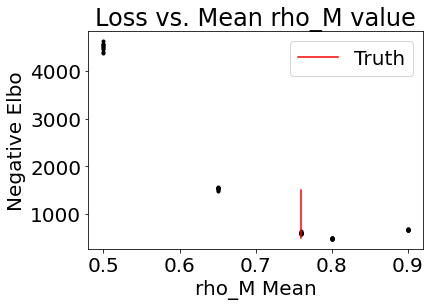

In [30]:

plt.plot(np.repeat(possibilities['rho_M'],10),
         losses['rho_M'], 'k.')
plt.plot([model_rho_M, model_rho_M], [500, 1500], 'r-', label='Truth')
plt.xlabel('rho_M Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean rho_M value")

Text(0.5, 1.0, 'Loss vs. Mean lambda_M value')

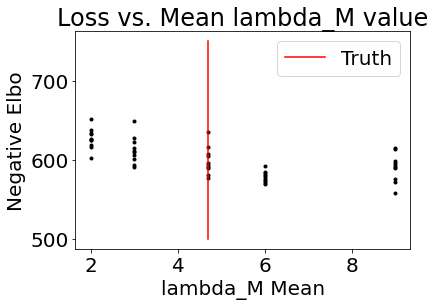

In [32]:

plt.plot(np.repeat(possibilities['lambda_M'],10),
         losses['lambda_M'], 'k.')
plt.plot([model_lambda_M, model_lambda_M], [500, 750], 'r-', label='Truth')
plt.xlabel('lambda_M Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean lambda_M value")

Text(0.5, 1.0, 'Loss vs. Mean nu_M value')

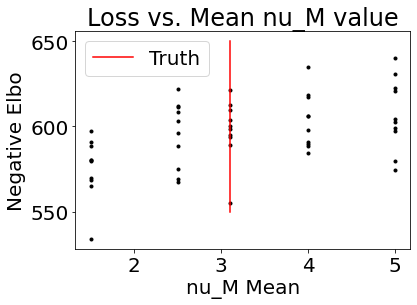

In [35]:

plt.plot(np.repeat(possibilities['nu_M'],10),
         losses['nu_M'], 'k.')
plt.plot([model_nu_M, model_nu_M], [550, 650], 'r-', label='Truth')
plt.xlabel('nu_M Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean nu_M value")

Text(0.5, 1.0, 'Loss vs. Mean Warmup A t-3 value')

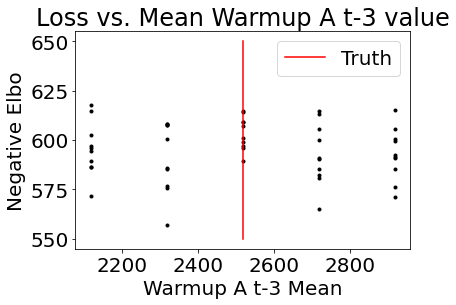

In [93]:

plt.plot(np.repeat(possibilities['warmup_asymp_-3'],10),
         losses['warmup_asymp_-3'], 'k.')
plt.plot([model_asymp[0], model_asymp[0]], [550, 650], 'r-', label='Truth')
plt.xlabel('Warmup A t-3 Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean Warmup A t-3 value")

Text(0.5, 1.0, 'Loss vs. Mean Warmup A t-2 value')

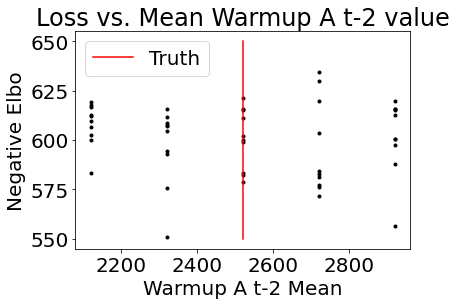

In [100]:

plt.plot(np.repeat(possibilities['warmup_asymp_-2'],10),
         losses['warmup_asymp_-2'], 'k.')
plt.plot([model_asymp[1], model_asymp[1]], [550, 650], 'r-', label='Truth')
plt.xlabel('Warmup A t-2 Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean Warmup A t-2 value")

Text(0.5, 1.0, 'Loss vs. Mean Warmup A t-1 value')

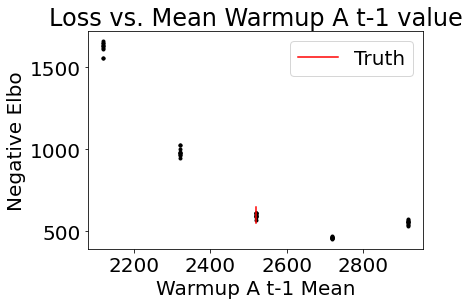

In [101]:

plt.plot(np.repeat(possibilities['warmup_asymp_-1'],10),
         losses['warmup_asymp_-1'], 'k.')
plt.plot([model_asymp[0], model_asymp[0]], [550, 650], 'r-', label='Truth')
plt.xlabel('Warmup A t-1 Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean Warmup A t-1 value")

In [54]:
possibilities

{'delta': [0.98, 0.985, 0.99, 0.995, 0.998],
 'T_serial': [3.0, 4.5, 5.8, 7.0, 9.0],
 'rho_M': [0.5, 0.65, 0.76, 0.8, 0.9],
 'lambda_M': [2.0, 3.0, 4.7, 6.0, 9.0],
 'nu_M': [1.5, 2.5, 3.1, 4.0, 5.0],
 'warmup_asymp_-3': [2518.60923786445,
  2718.60923786445,
  2918.60923786445,
  3118.60923786445,
  3318.60923786445],
 'warmup_asymp_-2': [2520.22371776634,
  2720.22371776634,
  2920.22371776634,
  3120.22371776634,
  3320.22371776634],
 'warmup_asymp_-1': [2518.626798999444,
  2718.626798999444,
  2918.626798999444,
  3118.626798999444,
  3318.626798999444]}

In [67]:
model_asymp

array([3318.60923786, 3720.22371777, 3718.626799  ])

In [64]:
warmup_asymp

array([2518.60923786, 2520.22371777, 2518.626799  ])

In [51]:
model_asymp[0]

2918.60923786445

In [77]:
possibilities['warmup_asymp_-3']

[2118.60923786445,
 2318.60923786445,
 2518.60923786445,
 2718.60923786445,
 2918.60923786445]

In [78]:
warmup_asymp

array([2518.60923786, 2520.22371777, 2518.626799  ])

In [80]:
model.losses

[]

In [84]:
model_delta

0.998

In [86]:
possibilities['delta']

[0.98, 0.985, 0.99, 0.995, 0.998]

In [89]:
synth_delta

0.99

In [94]:
param_scale_pct

0.1

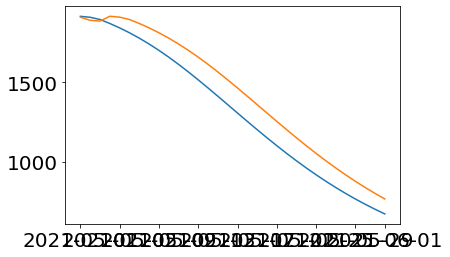

In [108]:
plt.plot(df.loc[train_start:train_end].index.values, tf.reduce_mean(result,axis=1))
plt.plot(df.loc[train_start:train_end].index.values, M_vals)